# Butterworth Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2

In [2]:
FP_IMAGE = "jbook/figures/mammogram.png"

In [3]:
def get_blpf(f: np.ndarray, order: int, cutoff: int):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)
    D0 = cutoff
    n = order
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1/(1+(D/D0)**(2*n))
    return H[u,v]


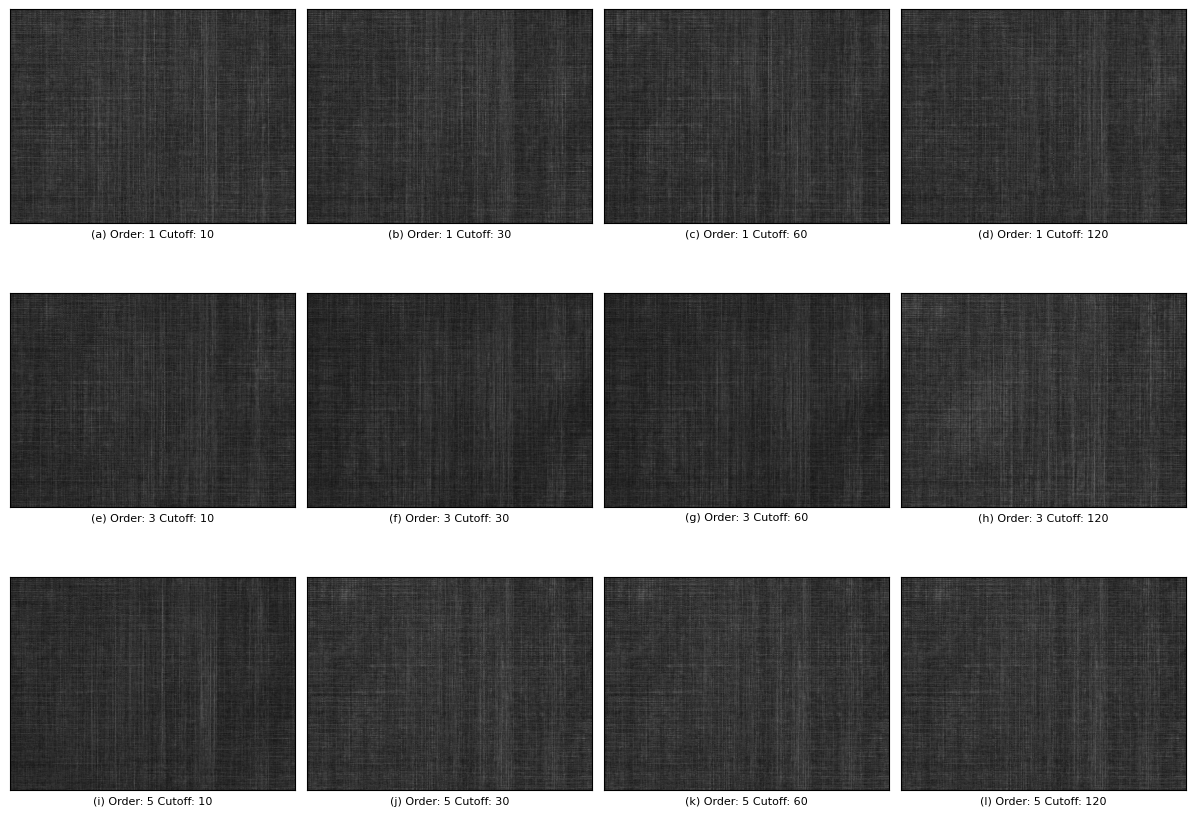

In [4]:
f = cv2.imread(FP_IMAGE, cv2.IMREAD_GRAYSCALE)
# Get M and N
M,N = f.shape
# Set P and Q
P = f.shape[0] * 2
Q = f.shape[1] * 2
# Pad the image
f_p = np.pad(f, [(0,P-M),(0,Q-N)],mode='constant', constant_values=0)
# Shift to center 
f_shift = np.fft.fftshift(f_p)
# Transform image to frequency domain
F = np.fft.fft2(f_shift)
# Cutoff Frequency
D0 = np.array([10,30,60,120])
n = np.array([1,3,5])
# Labels
labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"], ["(i)", '(j)', "(k)", "(l)"]])
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
for i in range(len(n)):
    for j in range(len(D0)):
        H = get_blpf(f_shift,n[i],D0[j])
        G_shift = F * H 
        G = np.fft.ifftshift(G_shift)
        g = np.abs(np.fft.ifft2(G))
        g = g[0:M,0:N]
        _ = axes[i,j].imshow(g, cmap='gray')
        label = f"{labels[i,j]} Order: {n[i]} Cutoff: {D0[j]}"
        _ = axes[i,j].set_xlabel(label)
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])
        
plt.tight_layout()
plt.show()

Text(0.5, 0.95, '(squared) Butterworth filtering (order=3.0, npad=0)')

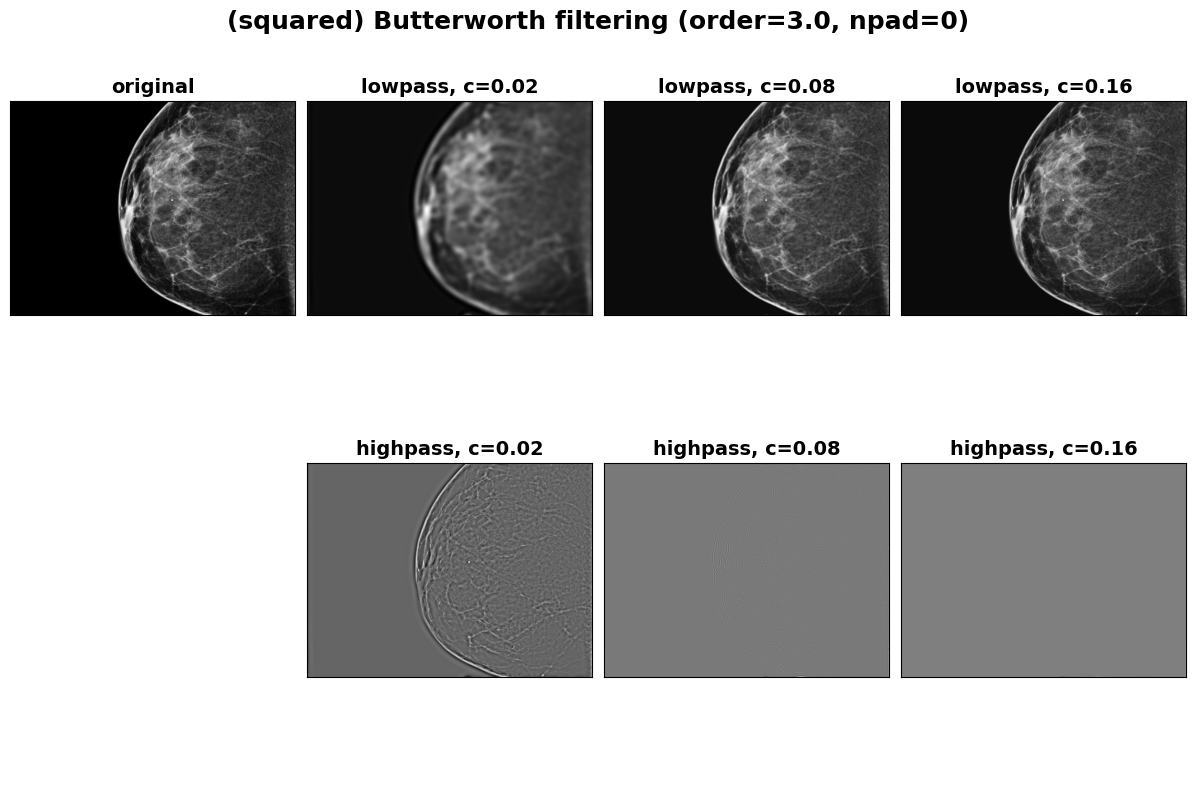

In [5]:
import matplotlib.pyplot as plt

from skimage import data, filters

image = cv2.imread(FP_IMAGE, cv2.IMREAD_GRAYSCALE)

# cutoff frequencies as a fraction of the maximum frequency
cutoffs = [.02, .08, .16]


def get_filtered(image, cutoffs, squared_butterworth=True, order=3.0, npad=0):
    """Lowpass and highpass butterworth filtering at all specified cutoffs.

    Parameters
    ----------
    image : ndarray
        The image to be filtered.
    cutoffs : sequence of int
        Both lowpass and highpass filtering will be performed for each cutoff
        frequency in `cutoffs`.
    squared_butterworth : bool, optional
        Whether the traditional Butterworth filter or its square is used.
    order : float, optional
        The order of the Butterworth filter

    Returns
    -------
    lowpass_filtered : list of ndarray
        List of images lowpass filtered at the frequencies in `cutoffs`.
    highpass_filtered : list of ndarray
        List of images highpass filtered at the frequencies in `cutoffs`.
    """

    lowpass_filtered = []
    highpass_filtered = []
    for cutoff in cutoffs:
        lowpass_filtered.append(
            filters.butterworth(
                image,
                cutoff_frequency_ratio=cutoff,
                order=order,
                high_pass=False,
                squared_butterworth=squared_butterworth,
                npad=npad,
            )
        )
        highpass_filtered.append(
            filters.butterworth(
                image,
                cutoff_frequency_ratio=cutoff,
                order=order,
                high_pass=True,
                squared_butterworth=squared_butterworth,
                npad=npad,
            )
        )
    return lowpass_filtered, highpass_filtered


def plot_filtered(lowpass_filtered, highpass_filtered, cutoffs):
    """Generate plots for paired lists of lowpass and highpass images."""
    fig, axes = plt.subplots(2, 1 + len(cutoffs), figsize=(12, 8))
    fontdict = dict(fontsize=14, fontweight='bold')

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('original', fontdict=fontdict)
    axes[1, 0].set_axis_off()

    for i, c in enumerate(cutoffs):
        axes[0, i + 1].imshow(lowpass_filtered[i], cmap='gray')
        axes[0, i + 1].set_title(f'lowpass, c={c}', fontdict=fontdict)
        axes[1, i + 1].imshow(highpass_filtered[i], cmap='gray')
        axes[1, i + 1].set_title(f'highpass, c={c}', fontdict=fontdict)

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    return fig, axes


# Perform filtering with the (squared) Butterworth filter at a range of
# cutoffs.
lowpasses, highpasses = get_filtered(image, cutoffs, squared_butterworth=True)

fig, axes = plot_filtered(lowpasses, highpasses, cutoffs)
titledict = dict(fontsize=18, fontweight='bold')
fig.text(0.5, 0.95, '(squared) Butterworth filtering (order=3.0, npad=0)',
         fontdict=titledict, horizontalalignment='center')